# Pneumonia Classification in Chest X-rays using Transer Learning <br> (ResNet-18) + Grad-Cam

Grad-CAM is a class-discriminative localization technique that generates visual explanations for decisions made by Convolutional Neural Networks (CNNs), highlighting the image regions that most influence a specific prediction.

Ramprasaath R. and colaborators stated:
> "Grad-CAM uses the gradient information flowing into the last convolutional layer of the CNN to understand the importance of each neuron for a decision of interest."

Implementation and Mechanism In AI-assisted medical diagnosis, transparency is critical; "black box" models may offer high accuracy but lack clinical justification. We implement Grad-CAM to validate that the model identifies genuine pathological patterns (such as lung consolidations) rather than irrelevant artifacts (edges or markers), thereby ensuring the system's reliability.

To achieve this, the algorithm leverages the network's last convolutional layer, as it is the final point where detailed spatial information is preserved before being collapsed by fully connected layers. Grad-CAM calculates the gradient of the target class score with respect to the feature maps of said layer. These gradients are globally averaged (Global Average Pooling) to obtain "neuron importance weights." Finally, a weighted linear combination of the activation maps is performed, followed by a ReLU function, resulting in a heatmap that isolates only the features contributing positively to the pathology detection.

You can find more details in the original [Grad-CAM: Visual Explanations from Deep Networks
via Gradient-based Localization](https://arxiv.org/pdf/1610.02391)

### 1. Import libraries

In [12]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# Data handling and preprocessing
import numpy as np
from tqdm import tqdm

# Visualization and evaluation
import matplotlib.pyplot as plt

# Configuration
sys.path.append(os.path.abspath(os.path.join("..")))
from src.data.dataloaders import get_loaders, get_transforms

# System and environment configuration
import cv2
import os
import sys
plt.style.use("seaborn-v0_8-muted")
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams["font.size"] = 11


In [ ]:
# Device Configuration

device = torch.device("mps" 
    if torch.backends.mps.is_available() 
    else "cuda" if torch.cuda.is_available() 
    else "cpu")
                      
print(f"Device: {device}")

Device: mps


In [ ]:
# Reconstruct the model architecture

def create_resnet_model(num_classes=2, dropout=0.5):
    """
    Reconstructs the exact architecture used during training.
    """
    weights = models.ResNet18_Weights.DEFAULT
    model = models.resnet18(weights=weights)
    
    # Ensure layers are frozen/unfrozen consistent with the saved state
    # For inference/GradCAM, we strictly need the structure to match.
    for param in model.parameters():
        param.requires_grad = False
        
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.BatchNorm1d(256),
        nn.Linear(256, num_classes)
    )
    return model

# Load weights of the best model
model = create_resnet_model().to(device)
model_path = "../models_saved/resnet_phase2.pth" 
# Verify the path matches your saved file (e.g., transfer_cnn.pth or resnet_phase2.pth)

if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model not found: {model_path}")

try:
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Model successfully loaded from: {model_path}")
except Exception as e:
    print(f"Error loading weights: {e}")

model.eval()

Model successfully loaded from: ../models_saved/resnet_phase2.pth


/var/folders/r3/nz7bfb694cv8lfq86vxg0lfr0000gn/T/ipykernel_20672/797044671.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Data Loaders

# Use the custom get_loaders function
_, test_loader = get_loaders(
    batch_size=16, 
    model_type="resnet", 
    data_dir="../data/chest_xray"
)

class_names = ["NORMAL", "PNEUMONIA"]
print(f"Test Loader initialized. Number of batches: {len(test_loader)}")

Apple Silicon detected. Setting num_workers to 0 for compatibility.
Test Loader initialized. Number of batches: 39


In [ ]:
# Grad-CAM Implementation

class GradCAM:
    """
    Implements Gradient-weighted Class Activation Mapping (Grad-CAM).
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Force gradient calculation for visualization
        for param in self.model.parameters():
            param.requires_grad = True
        self.model.eval()

        # Register hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        # Forward pass
        output = self.model(x)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1)
        
        # Backward pass
        self.model.zero_grad()
        target = output[0, class_idx]
        target.backward()

        if self.gradients is None:
            return np.zeros((x.shape[2], x.shape[3])), output, class_idx

        # Generate Heatmap
        pooled_gradients = torch.mean(self.gradients, dim=[2, 3])
        activations = self.activations.detach()
        
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[0, i]
            
        heatmap = torch.mean(activations, dim=1).squeeze().cpu()
        heatmap = np.maximum(heatmap, 0)
        
        if torch.max(heatmap) > 0:
            heatmap /= torch.max(heatmap)
            
        return heatmap.numpy(), output, class_idx

# Initialize GradCAM on the final convolutional layer 
gradcam = GradCAM(model, model.layer4)
print("Grad-CAM initialized on ResNet layer4.")

Grad-CAM initialized on ResNet layer4.


In [ ]:
# Helper Functions

def denormalize_image(img_tensor, device):
    """
    Denormalizes images using the specific statistics from dataloaders.py.
    """
    # ImageNet statistics matching your get_transforms function
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    
    img_denorm = img_tensor * std + mean
    img_denorm = torch.clamp(img_denorm, 0, 1)
    img_np = img_denorm[0].cpu().permute(1, 2, 0).numpy()
    img_np = (img_np * 255).astype(np.uint8)
    
    return img_np

def process_single_image(img_path, device):
    """
    Loads and preprocesses a single image using the custom get_transforms.
    """
    # 1. Get the exact transformation pipeline used for testing
    preprocess = get_transforms(img_size=224, model_type="resnet", train=False)
    
    try:
        # Open image
        img_pil = Image.open(img_path).convert("RGB")
        # Apply transformation (Resize -> Grayscale(3) -> Tensor -> Normalize)
        img_tensor = preprocess(img_pil).unsqueeze(0).to(device)
        return img_tensor
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        return None

def generate_visualization(gradcam, img_tensor, device, target_class=None):
    """
    Generates the heatmap and superimposed visualization.
    """
    img_np = denormalize_image(img_tensor, device)
    heatmap, output, pred_idx = gradcam(img_tensor, class_idx=target_class)
    
    # Resize heatmap to match image dimensions
    heatmap_resized = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    
    # Superposition (heatmap * 0.4 + original)
    superimposed = heatmap_colored[..., ::-1] * 0.4 + img_np.astype(float) / 255.0 * 255
    superimposed = superimposed / np.max(superimposed)
    
    # Get confidence
    probs = F.softmax(output, dim=1)
    confidence = probs[0, pred_idx].item()
    
    return heatmap_resized, superimposed, pred_idx, confidence


Generating basic visualizations...


/var/folders/r3/nz7bfb694cv8lfq86vxg0lfr0000gn/T/ipykernel_20672/3254115805.py:52: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap = np.maximum(heatmap, 0)


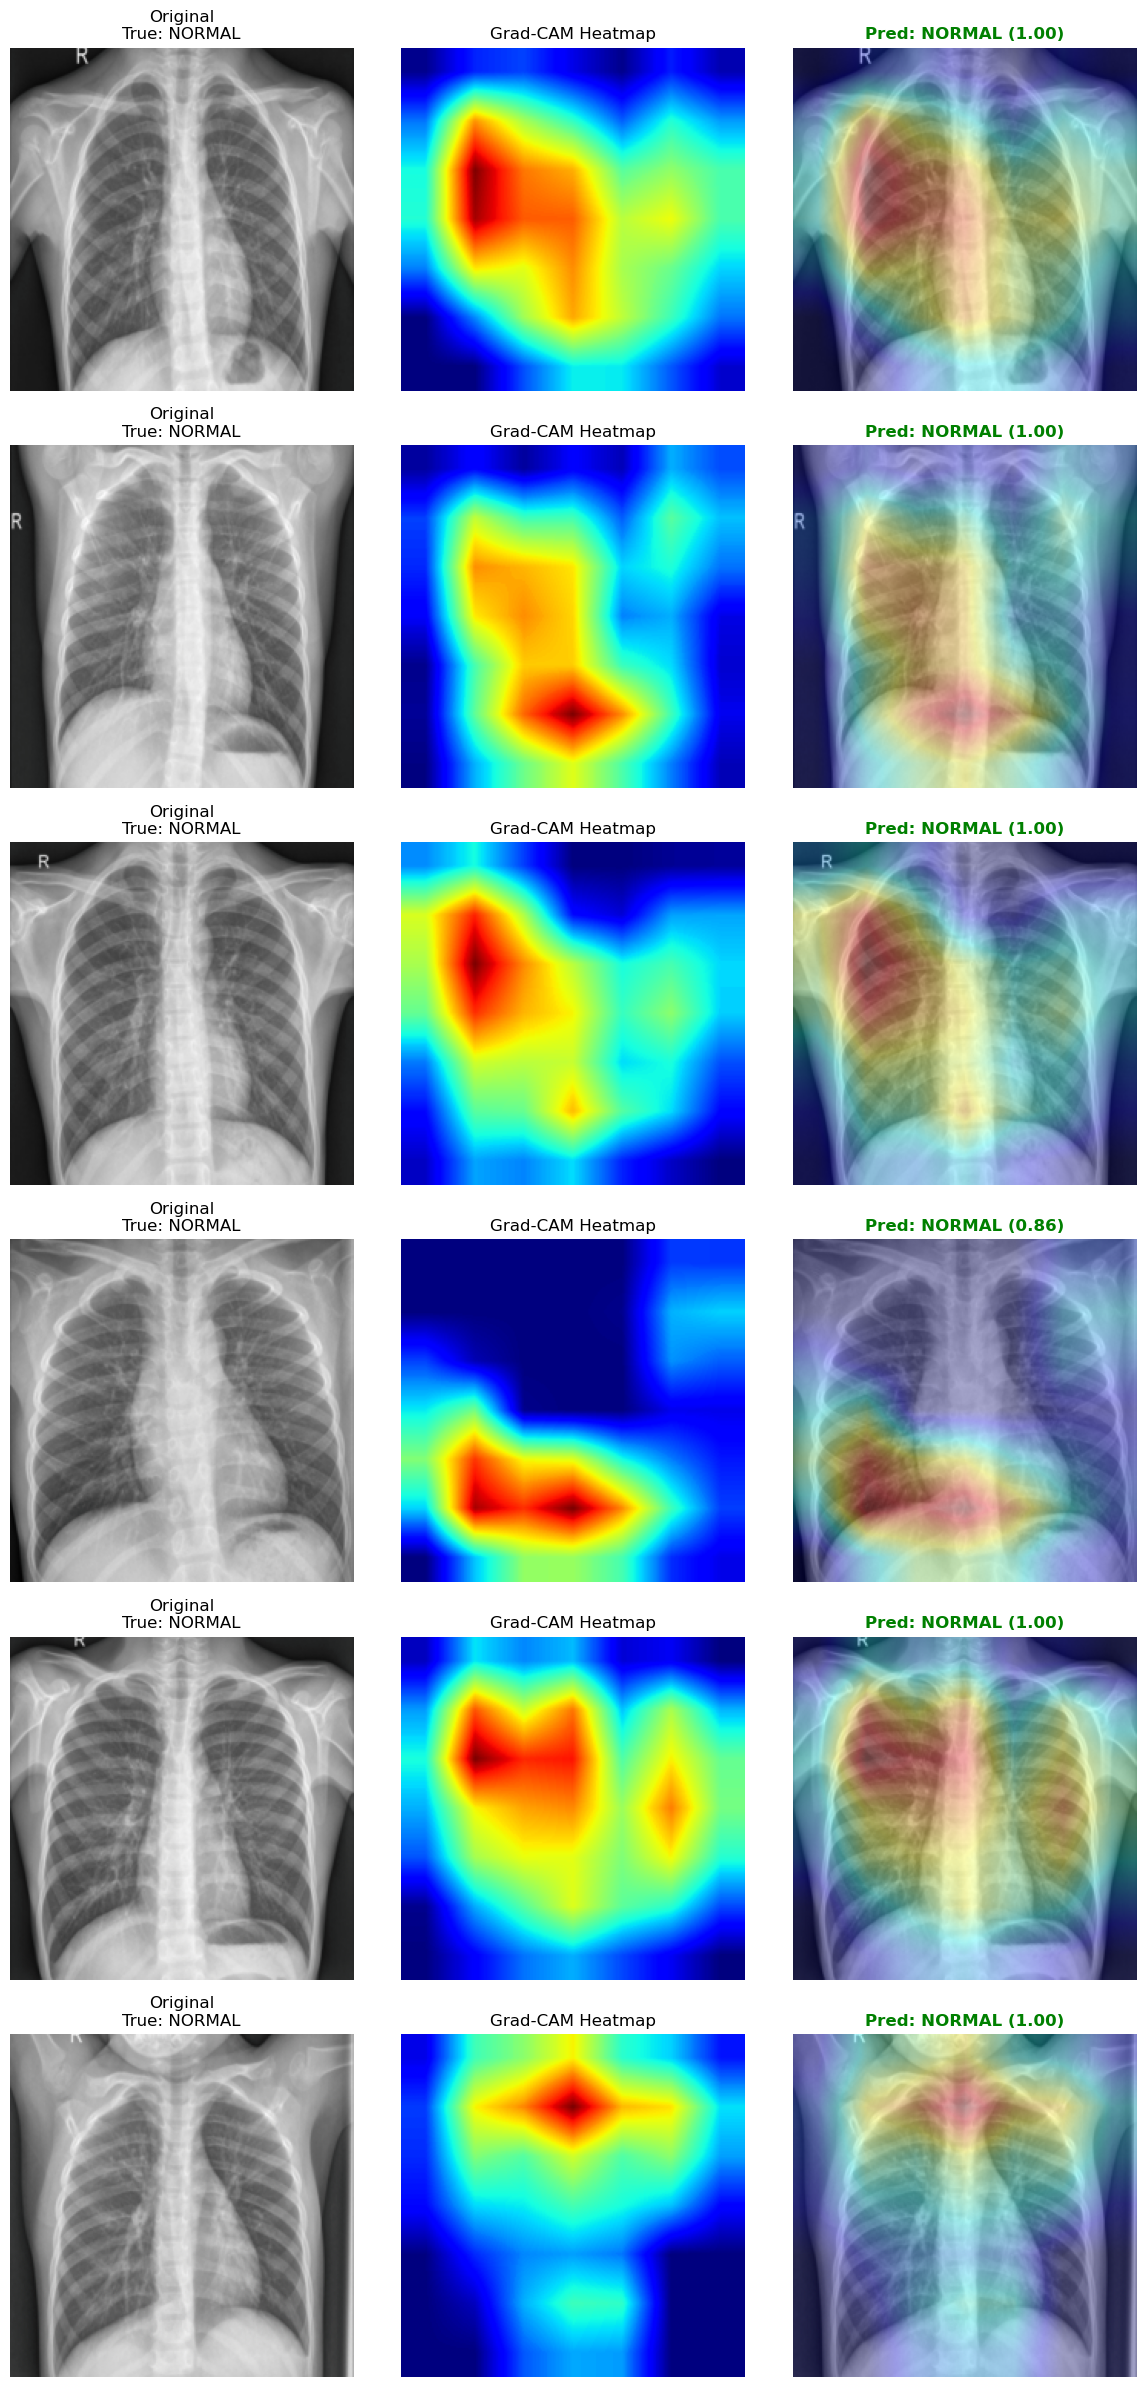

In [ ]:
# Visualizations 

def visualize_gradcam_samples(model, test_loader, gradcam, device, num_samples=6):
    """
    Visualizes Grad-CAM for multiple random samples from the test loader.
    """
    model.eval()
    
    # Get a batch
    images, labels = next(iter(test_loader))
    images = images[:num_samples].to(device)
    labels = labels[:num_samples]
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
    
    for idx in range(num_samples):
        img_tensor = images[idx:idx+1]
        true_label = labels[idx].item()
        
        # Generate Visualization
        heatmap, superimposed, pred_label, confidence = generate_visualization(
            gradcam, img_tensor, device
        )
        
        img_np = denormalize_image(img_tensor, device)
        
        # Plotting
        # Column 1: Original
        axes[idx, 0].imshow(img_np)
        axes[idx, 0].set_title(f"Original\nTrue: {class_names[true_label]}", fontsize=12)
        axes[idx, 0].axis("off")
        
        # Column 2: Heatmap
        axes[idx, 1].imshow(heatmap, cmap="jet")
        axes[idx, 1].set_title("Grad-CAM Heatmap", fontsize=12)
        axes[idx, 1].axis("off")
        
        # Column 3: Superimposed
        title_color = "green" if pred_label == true_label else "red"
        axes[idx, 2].imshow(superimposed)
        axes[idx, 2].set_title(
            f"Pred: {class_names[pred_label]} ({confidence:.2f})", 
            fontsize=12, color=title_color, weight="bold"
        )
        axes[idx, 2].axis("off")
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("Generating basic visualizations...")
print("="*60)
visualize_gradcam_samples(model, test_loader, gradcam, device, num_samples=6)

In [ ]:
# Single Image Analysis

def analyze_single_image(img_path, model, gradcam, device):
    """
    Analyzes a specific image file path.
    """
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        return

    # Process image using get_transforms
    img_tensor = process_single_image(img_path, device)
    
    if img_tensor is not None:
        heatmap, superimposed, pred_label, confidence = generate_visualization(
            gradcam, img_tensor, device
        )
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        img_np = denormalize_image(img_tensor, device)
        
        axes[0].imshow(img_np)
        axes[0].set_title("Original Image", fontsize=12)
        axes[0].axis("off")
        
        axes[1].imshow(heatmap, cmap="jet")
        axes[1].set_title("Heatmap", fontsize=12)
        axes[1].axis("off")
        
        axes[2].imshow(superimposed)
        axes[2].set_title(f"Prediction: {class_names[pred_label]} ({confidence:.2f})", fontsize=12, weight="bold")
        axes[2].axis("off")
        
        plt.tight_layout()
        plt.show()

# Example usage: Find a PNEUMONIA image from test set
test_dir_pneumonia = "../data/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg"
if os.path.exists(test_dir_pneumonia):
    images = [f for f in os.listdir(test_dir_pneumonia) if f.endswith(".jpeg")]
    if images:
        sample_path = os.path.join(test_dir_pneumonia, images[0])
        print(f"Analyzing specific image: {sample_path}")
        analyze_single_image(sample_path, model, gradcam, device)

NotADirectoryError: [Errno 20] Not a directory: '../data/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg'